## Phase difference methods

### Sine wave

$y(t) = A\sin(2 \pi f t + \varphi) = A\sin(\omega t + \varphi)$

where:
* ''A'' = the ''[[amplitude]]'', the peak deviation of the function from zero.
* ''f'' = the ''[[frequency|ordinary frequency]]'', the ''[[Real number|number]]'' of oscillations (cycles) that occur each second of time.
* ''ω'' = 2π''f'', the ''[[angular frequency]]'', the rate of change of the function argument in units of [[radian]]s per second
* ''$\varphi$'' = the ''[[Phase (waves)|phase]]'', specifies (in radians) where in its cycle the oscillation is at ''t'' = 0.

** When ''$\varphi$'' is non-zero, the entire waveform appears to be shifted in time by the amount ''$\varphi$''/''ω'' seconds.  A negative value represents a delay, and a positive value represents an advance (https://en.wikipedia.org/wiki/Sine_wave).

In [1]:
from matplotlib import pyplot as plt
from numpy.fft import fft, ifft
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
def sine_signal(
    t: np.array, A: float, f: float, φ: float
) -> pd.Series:
    """
    φ input in degree unit

    :param t:
    :type t:
    :param A:
    :type A:
    :param f:
    :type f:
    :param φ:
    :type φ:
    :return:
    :rtype:
    """
    ω = 2*np.pi*f
    return pd.Series(A*np.sin(ω*t + np.deg2rad(φ)), index=t)

## Method 1

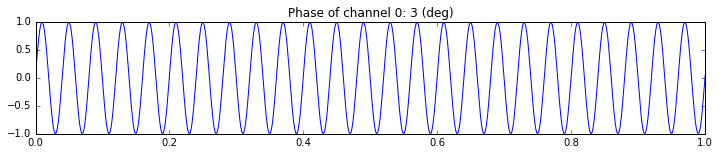

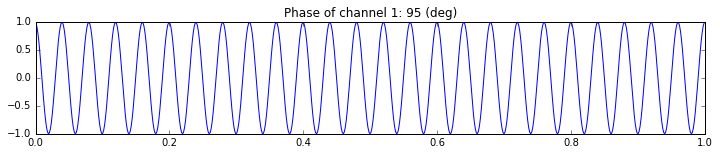

In [4]:
# GENERAL INFO
π = np.pi
channels = 2
φs = [3, 95]  # phase shift of each channel

f = 25

ns = 680
fs = 680

t = np.linspace(0, ns//fs, ns)

df = pd.DataFrame(np.zeros((ns, channels)), index=t)

for i in range(channels):
    φ = φs[i]
    title = 'Phase of channel %s: %s (deg)' % (i, φ)
    df[i] = sine_signal(t, A=1, f=f, φ=φ)
    df[i].plot(title=title, figsize=(12, 2))
    plt.show()

$\varphi = \arccos(\frac{a \cdot b}{\left\|a\right\| * \left\|b\right\|}) \text{rad} $

In [5]:
_df = df.iloc[1:, :].copy()

phase_diff = np.arccos(
    np.dot(_df[0], _df[1])/(
        np.linalg.norm(_df[0])*np.linalg.norm(_df[1])
    )
)*180/π

if np.isnan(phase_diff):
    phase_diff = 0.0

print(phase_diff)

92.0


## Test Mehod 1

In [6]:
status_success = 0
status_fail = 0

# print('ID', 'NOMINAL', 'ESTIMATED', 'STATUS', sep='\t')

for k in range(1000):
    φs = [
        np.random.randint(0, 180, 1)[0], 
        np.random.randint(0, 180, 1)[0]
    ]  # phase shift of each channel

    df = pd.DataFrame(np.zeros((ns, channels)), index=t)

    # signal generation
    for i in range(channels):
        φ = φs[i]
        title = 'Phase of channel %s: %s (deg)' % (i, φ)
        df[i] = sine_signal(t, A=1, f=f, φ=φ)
        
    nominal_diff = float(np.abs(φs[0]-φs[1]).astype(float))

    _df = df.iloc[1:, :].copy()

    phase_diff = np.round(np.arccos(
        np.dot(_df[0], _df[1])/(
            np.linalg.norm(_df[0])*np.linalg.norm(_df[1])
        )
    )*180/π)
    
    if np.isnan(phase_diff):
        phase_diff = 0.0
    
    # print(k, nominal_diff, phase_diff, '\t', sep='\t', end='')
    try:
        np.testing.assert_almost_equal(nominal_diff, phase_diff)
        status_success += 1
    except:
        status_fail += 1
    # print('OK')
    
print('SUCCESS: ', status_success, sep='\t')
print('FAIL: ', status_fail, sep='\t')

SUCCESS: 	1000
FAIL: 	0


## Method 2

Using FFT

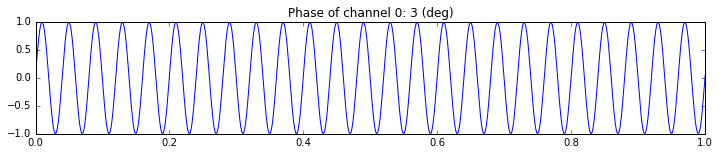

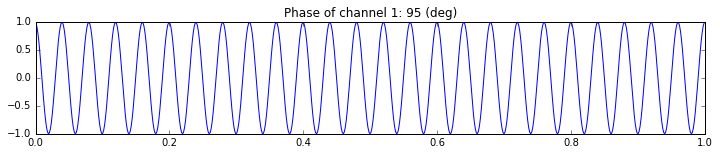

In [7]:
# GENERAL INFO
π = np.pi
channels = 2
φs = [3, 95]  # phase shift of each channel

f = 25

ns = 680
fs = 680

t = np.linspace(0, ns//fs, ns)

df = pd.DataFrame(np.zeros((ns, channels)), index=t)

for i in range(channels):
    φ = φs[i]
    title = 'Phase of channel %s: %s (deg)' % (i, φ)
    df[i] = sine_signal(t, A=1, f=f, φ=φ)
    df[i].plot(title=title, figsize=(12, 2))
    plt.show()

In [8]:
# need to remove the final term
# the 1st term here could be confused, but the 
# phase diff between the 2 signal will be right too
_df = df.iloc[:-1].copy()

xdft_1 = fft(_df[0])
xdft_2 = fft(_df[1])

phase_shift_1 = np.angle(xdft_1[f])+π/2
phase_shift_2 = np.angle(xdft_2[f])+π/2

phase_shift_1*180/π, phase_shift_2*180/π

(2.9999999999998259, 95.000000000000128)

## Test Method 2

In [9]:
status_success = 0
status_fail = 0

# print('ID', 'NOMINAL', 'ESTIMATED', 'STATUS', sep='\t')

for k in range(1000):
    φs = [
        np.random.randint(0, 180, 1)[0], 
        np.random.randint(0, 180, 1)[0]
    ]  # phase shift of each channel

    df = pd.DataFrame(np.zeros((ns, channels)), index=t)

    # signal generation
    for i in range(channels):
        φ = φs[i]
        title = 'Phase of channel %s: %s (deg)' % (i, φ)
        df[i] = sine_signal(t, A=1, f=f, φ=φ)
        
    nominal_diff = float(np.abs(φs[0]-φs[1]).astype(float))

    _df = df.iloc[:-1, :].copy()
    
    xdft_1 = fft(_df[0])
    xdft_2 = fft(_df[1])

    phase_shift_1 = np.angle(xdft_1[f])+π/2
    phase_shift_2 = np.angle(xdft_2[f])+π/2

    phase_diff = np.abs(phase_shift_1-phase_shift_2)*180/π
    
    if np.isnan(phase_diff):
        phase_diff = 0.0
    
    # print(k, nominal_diff, phase_diff, '\t', sep='\t', end='')
    try:
        np.testing.assert_almost_equal(nominal_diff, phase_diff)
        status_success += 1
    except:
        status_fail += 1
    # print('OK')
    
print('SUCCESS: ', status_success, sep='\t')
print('FAIL: ', status_fail, sep='\t')

SUCCESS: 	1000
FAIL: 	0
